In [1]:
"""
Here, we are going to work on implementing Equations 14 and 15 from the simulation paper 
"Simulating low-frequency wind fluctuations" (roughly) -- Mann and Syed 2024.
"""

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.special as special

from typing import Optional

import sys
sys.path.append("..")

import low_freq_prototype as lfp

import Fij_numerical_integrator as fij

## Equation 14

The following is the "full version" of the integral used to solve for the
Fourier coefficients.


$$ C_ij^*({\bf k}) C_ij({\bf k}) = \int \phi_{ij}({\bf k'}) \prod_{l=1}^2
\operatorname{sinc}^2\left( \frac{(k_l - k_{l'} L_l)}{2} \right) \rm{d}\mathbf{k'}$$


# Equation 15

In the case that both $L_1, L_2 \gg L_{2D}$, we will use

$$ C_{ij}^*({\bf k}) C_{ij}({\bf k}) = \frac{4\pi^2}{L_1 L_2} \phi_{ij}({\bf k}) $$

FYI just take the sqrt of the RHS to get the
$C_{ij}$


# Equation 12
Recall that

$$u_i( \mathbf{x} ) = \sum_{\mathbf{k}} \operatorname{exp}(\imath \mathbf{k} \cdot \mathbf{x}) C_{ij}(\mathbf{k}) n_j(\mathbf{k})$$



In [2]:
spectral_tensor_eval_map = {
    (1, 1): fij.spectral_tensor_11,
    (1, 2): fij.spectral_tensor_12,
    (2, 1): fij.spectral_tensor_21,
    (2, 2): fij.spectral_tensor_22,
}

"""
The first row of figure 2 simulation -- 40 L x 5 L

sigma2 = 2.0, z_i = 500.0, psi = 45.0 degs
"""

# Parameters for this plot
L2D = 15_000.0
sigma2 = 2.0
z_i = 500.0
psi = np.deg2rad(45.0)
c = 1.0

grid_dimensions = np.array([40 * L2D, 5 * L2D])
grid_levels = np.array([10, 6])

#####################################################################
# Base calculations/setup

# Number of grid points in each dimension
N1, N2 = 2 ** grid_levels
L1, L2 = grid_dimensions

dx, dy = grid_dimensions / grid_levels

###
# Collect wave vectors

m1 = np.arange(-N1//2, N1//2)
m2 = np.arange(-N2//2, N2//2)

k1_arr = m1 * 2.0 * np.pi / L1
k2_arr = m2 * 2.0 * np.pi / L2

assert len(k1_arr) == N1
assert len(k2_arr) == N2

In [3]:
def Cij_of_k(k1, k2, ij, psi, L1, L2, L2D, z_i, c):
    phi_ij = spectral_tensor_eval_map[ij](k1, k2, psi, L2D, z_i, c)

    return (2 * np.pi)**2 * phi_ij / (L1 * L2)


In [10]:
Cij_of_k(k1_arr[N1//2 + 3], k2_arr[N2//2 + 3], (1,1), psi, L1, L2, L2D, z_i, c)

0.0

In [5]:
"""
So, now I have k1, k2 = arrays of length N1, N2 respectively which have all the wave numbers

FIRST ATTEMPT:
    I'm going to try to just use the matrices below. Then C_ij of k_1, k_2 is at [m,n] in C_ij_of_k
    where
        k_1 = k1_arr[m],           k_2 = k2_arr[n].
"""


C_11_of_k = np.zeros((N1, N2), dtype=np.complex128)
C_12_21_of_k = np.zeros((N1, N2), dtype=np.complex128)
C_22_of_k = np.zeros((N1, N2), dtype=np.complex128)


for m in range(N1):
    for n in range(N2):

        C_11_of_k[m,n] = Cij_of_k(k1_arr[m], k2_arr[n], (1,1), psi, L1, L2, L2D, z_i, c)
        C_12_21_of_k[m,n] = Cij_of_k(k1_arr[m], k2_arr[n], (1,2), psi, L1, L2, L2D, z_i, c)
        C_22_of_k[m,n] = Cij_of_k(k1_arr[m], k2_arr[n], (2,2), psi, L1, L2, L2D, z_i, c)




/Users/matthewmeeker/OPEN_SOURCE/DRDMannTurb/examples-unrendered/MM_random_dev/Fij_numerical_integrator.py:9: RuntimeWarning: invalid value encountered in divide
  return np.where(np.isclose(denominator, 0.0), safe_value, numerator/denominator)
/Users/matthewmeeker/OPEN_SOURCE/DRDMannTurb/examples-unrendered/MM_random_dev/Fij_numerical_integrator.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(np.isclose(denominator, 0.0), safe_value, numerator/denominator)


In [7]:
np.max(C_11_of_k)

0j

In [ ]:
# Ok, now for all fourier coeffiecnts
print("Obtaining Fourier coefficients")

k1_arr = 2.0 * np.pi * np.fft.fftfreq(N1, d=dx)
k2_arr = 2.0 * np.pi * np.fft.fftfreq(N2, d=dy)


# Equation 16


"Usually, $L_{2} \ll L_{2D}$ when simulating wind fields for single wind turbine load calculations."

In this case, we use

$$ 
C_{ij}^*({\bf k}) C_{ij}({\bf k}) = \frac{2\pi}{L_1}
\int \phi_{ij}(k_1, k_2') \operatorname{sinc}^2\left(
    \frac{(k_2 - k_2') L_2}{2}
\right) ~ \rm{d}k_2'
$$

In [5]:
import low_freq_prototype as lfp

In [11]:
L2D = 15_000.0
sigma2 = 2.0
z_i = 500.0
psi = np.deg2rad(45.0)

c = 1.0

####

L1 = L2D
L2 = L2D / 8

nx_exp = 10
ny_exp = 6

nx = 2**nx_exp
ny = 2**ny_exp


gen = lfp.LowFreq2DFieldGenerator(
    np.array([L1, L2]),
    np.array([nx_exp, ny_exp]),
    L_2D=L2D,
    sigma2=sigma2,
    z_i=z_i,
    psi_degs=psi,
    c=c,
)

In [18]:
_, _, u_field = gen.generate(pad = False)
_, _, v_field = gen.generate(pad = False)

In [20]:
from scipy.fft import fft2, fftfreq, fftshift

In [19]:
u_field.shape

(1024, 64)

In [23]:
U = fftshift(fft2(u_field))
# V = fftshift(fft2(v_field))

k1 = fftshift(fftfreq(nx, d=L1/nx))
k2 = fftshift(fftfreq(ny, d=L2/ny))

psd_2d = np.abs(U)**2 / (nx * ny)


F11 = np.mean(psd_2d, axis=1) * (ny * dy)

In [24]:
energy_spatial = np.mean(u_field**2) * (nx * dx) * (ny * dy)

energy_spectral = np.sum(F11) * (k1[1] - k1[0])

print(f"Spatial energy: {energy_spatial:.4f}, Spectral energy: {energy_spectral:.4f}")


Spatial energy: 98304000000000.0000, Spectral energy: 109226.6667


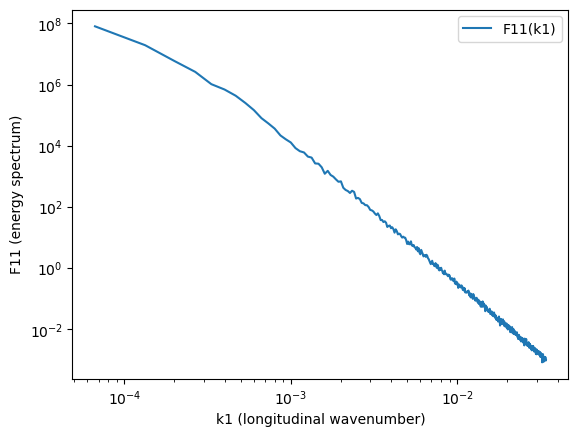

In [25]:
plt.loglog(k1[k1 > 0], F11[k1 > 0], label='F11(k1)')
plt.xlabel('k1 (longitudinal wavenumber)')
plt.ylabel('F11 (energy spectrum)')
plt.legend()
plt.show()

Variance of u1: 0.0000, Variance of u2: 0.0000
Target variance: 4.0000


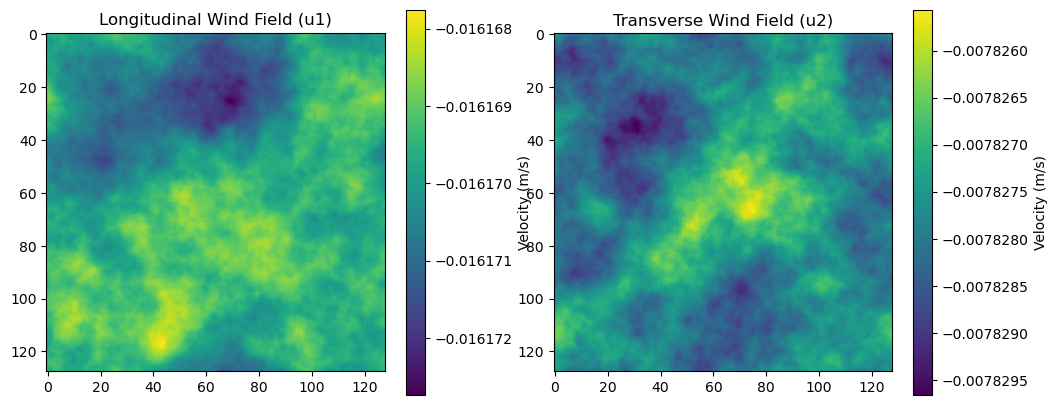

In [ ]:
import numpy as np
from scipy.fft import fftfreq, fft2, ifft2
import matplotlib.pyplot as plt

# Parameters from the model
sigma_2d = 2.0  # Variance of low-frequency fluctuations
L_2d = 15_000.0    # Mesoscale length scale (meters)
psi = np.deg2rad(45)       # Anisotropy parameter (angle in radians or as described)
z_i = 500.0    # Attenuation length (boundary-layer height, meters)
N1, N2 = 128, 128  # Grid points in longitudinal and transverse directions
dx, dy = 1.0, 1.0  # Grid spacings (meters)

# Grid sizes
L1 = N1 * dx  # Total length in longitudinal direction
L2 = N2 * dy  # Total length in transverse direction

# Wavenumbers (centered at zero)
k1 = 2 * np.pi * fftfreq(N1, d=dx)  # Longitudinal wavenumbers
k2 = 2 * np.pi * fftfreq(N2, d=dy)  # Transverse wavenumbers
k1, k2 = np.meshgrid(k1, k2)  # 2D wavenumber grid

# Target spectrum phi_ij(k) - Simplified example (Mann's model often uses Kaimal or von Kármán spectra)
# Here, we'll use a simple isotropic 2D spectrum for demonstration

# TODO: anistropy
# kappa = 


k_mag = np.sqrt(k1**2 + k2**2)  # Magnitude of wavenumber
phi_11 = sigma_2d**2 * (L_2d / (1 + (k_mag * L_2d)**2))**(5/3)  # Longitudinal spectrum (example)
phi_22 = phi_11  # Transverse spectrum (isotropic for simplicity)
phi_12 = np.zeros_like(phi_11)  # Cross-spectrum (zero for simplicity)

# TODO: need to fix this for cross-correlation
# Coherence function C_ij(k) - Simplified using equation (15)
# C_ij^*(k) C_ij(k) = (2π)^2 / (L1 L2) * phi_ij(k)
C_11 = np.sqrt((2 * np.pi)**2 / (L1 * L2) * phi_11)
C_22 = np.sqrt((2 * np.pi)**2 / (L1 * L2) * phi_22)
C_12 = np.zeros_like(C_11)  # No cross-correlation for simplicity

# Generate independent Gaussian random variables η_j(k)
eta_1 = np.random.normal(0, 1, size=(N1, N2)) + 1j * np.random.normal(0, 1, size=(N1, N2))
eta_2 = np.random.normal(0, 1, size=(N1, N2)) + 1j * np.random.normal(0, 1, size=(N1, N2))

# Compute the wind field using Fourier sum (equation 12)
# u_i(x) = ∑_k exp(i k · x) C_ij(k) η_j(k)
# We'll use inverse FFT for efficiency
u1 = ifft2(C_11 * eta_1)  # Longitudinal component
u2 = ifft2(C_22 * eta_2)  # Transverse component

# Take real part (since physical velocity is real)
u1 = np.real(u1)
u2 = np.real(u2)

# Apply attenuation (if needed, based on z_i and height)
# For simplicity, assume uniform height or no attenuation here
# If height data is available, multiply by exp(-z / z_i)

# Verify total variance (should match sigma_2d^2)
var_u1 = np.var(u1)
var_u2 = np.var(u2)
print(f"Variance of u1: {var_u1:.4f}, Variance of u2: {var_u2:.4f}")
print(f"Target variance: {sigma_2d**2:.4f}")

# Plot the wind field
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(u1, cmap='viridis')
plt.title('Longitudinal Wind Field (u1)')
plt.colorbar(label='Velocity (m/s)')

plt.subplot(122)
plt.imshow(u2, cmap='viridis')
plt.title('Transverse Wind Field (u2)')
plt.colorbar(label='Velocity (m/s)')
plt.show()

# Calculate F11 off of a generated field

We have two relations

$$ \phi_{ij}(k_1,k_2) = \int\int R_{ij}^{2D} (x_1, x_2) \operatorname{exp}(-i {\bf k} \cdot {\bf x})~ {\rm d}x_1 ~ {\rm d}x_2 = \langle \hat{u}^*(k_1, k_2) \hat{u}_j (k_1, k_2) \rangle$$
and
$$ F_{ij}(k_1) = \int \phi_{ij}(k_1,k_2) ~ {\rm d} k_2 $$

Substituting,
$$ F_{ij}(k_1) = \int \langle \hat{u}_i^*(k_1, k_2) \hat{u}_j (k_1, k_2) \rangle ~{\rm d} k_2 $$

And so

$$ F_{11}(k_1) = \int \langle \hat{u}_1^*(k_1, k_2) \hat{u}_1 (k_1, k_2) \rangle ~{\rm d} k_2 $$
and
$$ F_{22}(k_1) = \int \langle \hat{u}_2^*(k_1, k_2) \hat{u}_2 (k_1, k_2) \rangle ~{\rm d} k_2 $$

In [13]:
u1 = field[2]

In [23]:
print(u1)
print(np.max(u1))
print(np.mean(u1))
print(np.min(u1))


[[ 0.18952545  0.99264825  0.98547869 ... -0.62142271 -0.45074959
  -0.76451489]
 [ 0.1905333   0.98643594  0.98452572 ... -0.6154473  -0.44725403
  -0.76541042]
 [ 0.19154206  0.9803007   0.98380356 ... -0.6094375  -0.44347057
  -0.76581094]
 ...
 [ 0.18735015  1.0099934   0.99148528 ... -0.63663742 -0.46102739
  -0.7609551 ]
 [ 0.18766495  1.00440113  0.98908366 ... -0.63173694 -0.45759921
  -0.76222369]
 [ 0.18854428  0.99868237  0.98691458 ... -0.62681957 -0.45411735
  -0.76331232]]
3.4161218839766865
-2.7755575615628914e-17
-4.650074008457566


In [24]:
u1_hat = np.fft.fft2(u1)
print(u1_hat)
print(np.mean(u1_hat))
print(np.max(u1_hat))
print(np.min(u1_hat))


[[ 1.78945747e-12+0.00000000e+00j -7.09684548e+03-2.38273364e+04j
   2.17051480e+04-4.21596286e+04j ... -7.52136157e+03+9.33114752e+03j
   2.17051480e+04+4.21596286e+04j -7.09684548e+03+2.38273364e+04j]
 [-6.95200189e+01+6.20354200e+03j  1.86889602e+03-1.41055457e+03j
   6.23913128e+02-8.57900417e+03j ... -2.65896689e+03-3.70848034e+02j
   6.76371846e+03+3.00217083e+03j -2.14381487e+03+3.42238198e+02j]
 [ 6.35543492e+02-1.57276366e+02j  5.80928337e+02+3.38675061e+02j
   7.98249279e+02-1.67636409e+03j ...  1.17320638e+02-2.32406441e+02j
  -6.69008773e+02-1.24492103e+03j -1.81902250e+02+3.60676004e+02j]
 ...
 [ 8.21533880e+02-8.96761859e+01j  2.51107316e+02-5.11006463e+02j
   3.33754350e+00-2.62712879e+01j ... -4.22165952e+02+5.88457587e+01j
  -2.15771069e+02-7.51148593e+02j  7.27171209e+02+7.61331786e+01j]
 [ 6.35543492e+02+1.57276366e+02j -1.81902250e+02-3.60676004e+02j
  -6.69008773e+02+1.24492103e+03j ... -1.02995669e+03-1.68186031e+03j
   7.98249279e+02+1.67636409e+03j  5.80928337e+

In [25]:
u1_hat_star = np.conj(u1_hat)

u1_hat_squared = u1_hat * u1_hat_star


print(u1_hat_squared)
print(np.max(u1_hat_squared))
print(np.mean(u1_hat_squared))
print()

u1_hat_squared_real = np.real(u1_hat_squared)
u1_hat_squared_imag = np.imag(u1_hat_squared)

print(np.max(u1_hat_squared_imag))
print(np.mean(u1_hat_squared_imag))
print(np.min(u1_hat_squared_imag))
print()

print(np.max(u1_hat_squared_real))
print(np.mean(u1_hat_squared_real))
print(np.min(u1_hat_squared_real))



[[3.20215804e-24+0.00000000e+00j 6.18107178e+08+7.08683372e-09j
  2.24854773e+09+1.89061184e-08j ... 1.43641194e+08+3.13318619e-09j
  2.24854773e+09-1.89061184e-08j 6.18107178e+08+1.04465241e-09j]
 [3.84887664e+07-2.19216459e-11j 5.48243653e+06-8.68466346e-11j
  7.39885802e+07-3.09561358e-10j ... 7.20763317e+06-3.45199248e-11j
  5.47609172e+07-1.78433335e-09j 4.71306919e+06+2.94005951e-11j]
 [4.28651386e+05+6.38520443e-12j 4.52178530e+05+1.27796958e-11j
  3.44739849e+06+6.60251357e-14j ... 6.77768860e+04+1.40874836e-12j
  1.99740111e+06+1.71126572e-11j 1.63175609e+05-4.24863908e-12j]
 ...
 [6.82959735e+05-2.14726662e-12j 3.24182490e+05+1.25746060e-12j
  7.01319764e+02+1.11419526e-15j ... 1.81686914e+05-9.52417290e-13j
  6.10781362e+05+1.41187535e-11j 5.34574228e+05-2.40417275e-12j]
 [4.28651386e+05-6.20222463e-12j 1.63175609e+05-6.00238950e-12j
  1.99740111e+06+8.00315630e-12j ... 3.88946490e+06+2.67258068e-11j
  3.44739849e+06+3.31044257e-11j 4.52178530e+05-8.86157343e-12j]
 [3.848876

(1024, 64)


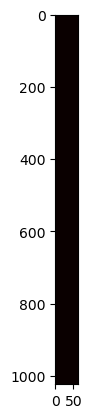

In [26]:
print(u1_hat_squared.shape)


plt.imshow((u1_hat_squared_real), cmap="hot", interpolation="nearest")
plt.show()

# Recreate Fig 2

Average error with attenuation: 0.0000000016
Max error with attenuation: 0.0000000016
L2 norm with attenuation: 0.0000000016


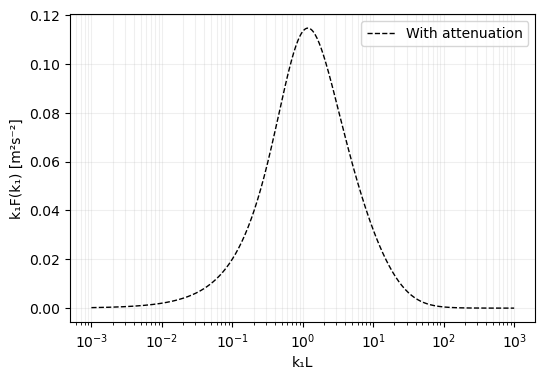

In [27]:
"""
This cell aims to recreate Figure 1 in the theory paper.
"""

plt.clf(); plt.close('all');

L2D = 20_000 # km
z_i = 500 # m
psi = np.deg2rad(43)
c = 5e-8
k1L = np.logspace(-3, 3, 400)

atten_err_list = []
numerical_F11_attenuated = []

for k1 in k1L:
    atten_res, atten_err = fij.eq6_numerical_F11_2D(k1 / L2D, psi, L2D, z_i, c)

    atten_err_list.append(atten_err)
    numerical_F11_attenuated.append(k1 * atten_res)

############################################
# Print some basic stats for the integration errors

print(f"Average error with attenuation: {np.mean(atten_err):.10f}")
print(f"Max error with attenuation: {np.max(atten_err):.10f}")
print(f"L2 norm with attenuation: {np.linalg.norm(atten_err):.10f}")

############################################
# Plot

plt.figure(figsize=(6, 4))

plt.plot(k1L, numerical_F11_attenuated, "--", color="black", label="With attenuation", linewidth=1)
plt.xscale("log")
plt.xlabel("k₁L")
plt.ylabel("k₁F(k₁) [m²s⁻²]")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

In [ ]:
# First Fig 2 row is
# 40 L x 5 L

In [ ]:
# Second Fig 2 row is
# L x 0.125 L